# Gradient Descent Regression example

In this notebook, an example using the gradient descent method for regression is presented.
For the data, the "Boston House Prices" dataset from kaggle (https://www.kaggle.com/datasets/vikrishnan/boston-house-prices) is used where we try and predict the price of houses in Boston.

First, import the required libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import sys

import os
sys.path.insert(0, str(Path(os.path.abspath('')).resolve().parent))
os.chdir(Path(os.path.abspath('')).resolve().parent)

data_path = Path(os.path.abspath('')).resolve() / "Examples" / "example data" / "Boston Housing Prices"

import OrionML as orn

The data is imported in a pandas DataFrame and the first 5 columns of the data are displayed. The Columns are:

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per \$10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of black people by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in \$1000's

In [4]:
column_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]

df = pd.read_csv(data_path / "housing.csv", delimiter=r"\s+", header=None, names=column_names)

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Data Cleaning

Let's check for any missing values and duplicate rows in the dataset.

In [10]:
print("Number of missing values in each column: ")
display(df.isnull().sum())

duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

Number of missing values in each column: 


CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


Number of duplicate rows: 0


## Price Prediction

We use the RM, AGE, DIS, RAD and TAX columns to try and predict MEDV. To do this, we select the desired columns from the data and split them into a test and validation set. The random seed that numpy uses is also set for reproducability.

In [209]:
np.random.seed(0)

data = df[["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]]
data_arr = np.array(data)

train, val = orn.utils.train_test_split(data_arr, train=0.8, shuffle=True)
train_X = train[:,:-1]
train_y = train[:,-1].reshape(-1,1)
val_X = val[:,:-1]
val_y = val[:,-1].reshape(-1,1)

Now a object of type orn.method.GDRegressor is created and the training data is fit to the training targets. Next, let's look at the linear correlation between all different columns.

<Axes: >

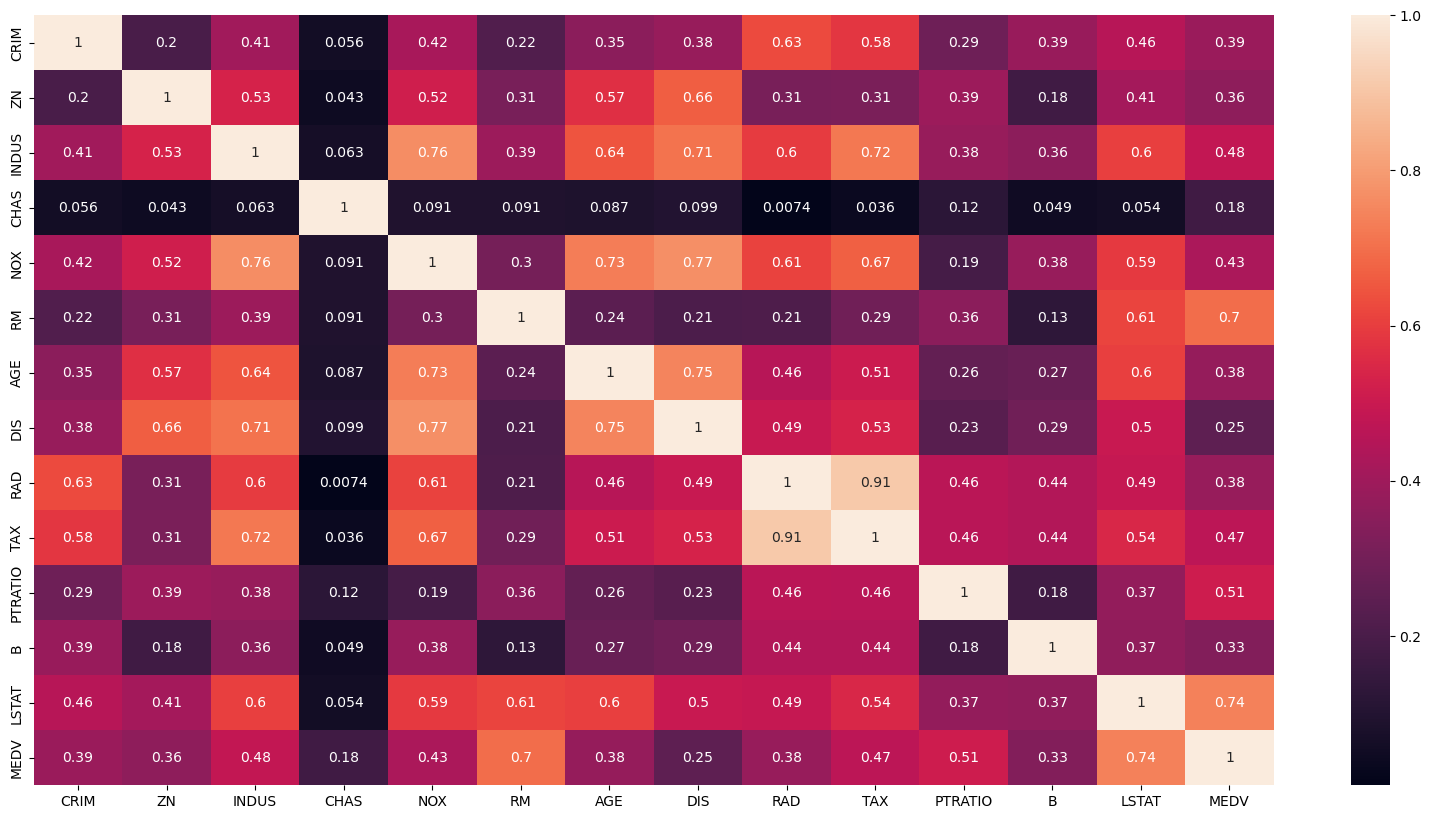

In [212]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr().abs(), annot=True)

Now we can train a model. Linear regression with gradient descent is very inefficient when the target depends on multiple variables, so a lot of Epochs are needed to get a good result. Let's go with 1'000'000 for now, but this can be increased to get a better model. Additionally, a L2 regularizer is used.

In [215]:
clf = orn.method.GDRegressor(loss_function="squared_error", learning_rate=3e-6, num_iters=1000000, verbose=True, batch_size=None, penalty="L2")

clf.fit(train_X, train_y)

Jh, wh, bh = clf.history
Jh=np.array(Jh)
Jh_val = np.array([orn.Loss.mse().value(val_y, np.matmul(val_X, wi)+bi) for wi,bi in zip(wh, bh)])

Iteration    0: Cost 48123.4595
Iteration 100000: Cost  35.3790
Iteration 200000: Cost  30.5184
Iteration 300000: Cost  28.3733
Iteration 400000: Cost  27.4078
Iteration 500000: Cost  26.9653
Iteration 600000: Cost  26.7575
Iteration 700000: Cost  26.6558
Iteration 800000: Cost  26.6023
Iteration 900000: Cost  26.5711


The training and validation loss can be seen below. The loss on the y-axis is on a logarithmic scale.

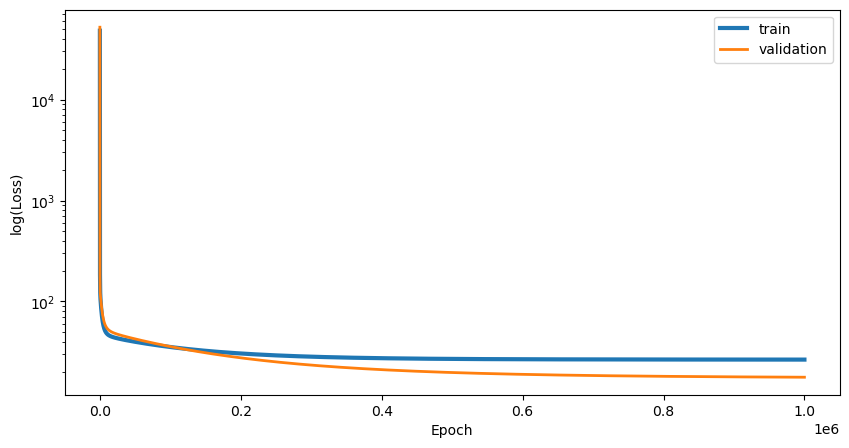

In [218]:
plt.figure(figsize=(10,5))

plt.plot(np.arange(1000000), Jh, linewidth = 3, label = "train")
plt.plot(np.arange(1000000), Jh_val, linewidth = 2, label = "validation")
plt.legend(loc="best")
plt.yscale("log")
plt.xlabel(xlabel="Epoch")
plt.ylabel(ylabel="log(Loss)")
plt.show()

There is immediately a very steep dropoff, so let's look at the loss after 100'000 epochs.

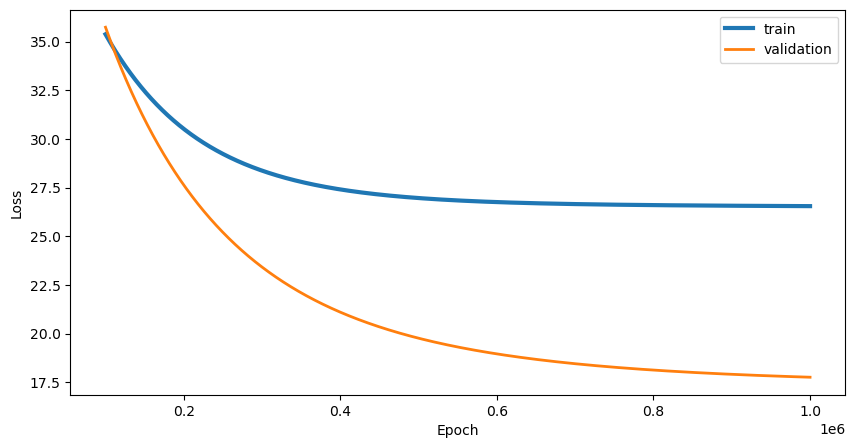

In [221]:
plt.figure(figsize=(10,5))

start_epoch = 100000

plt.plot(np.arange(1000000)[start_epoch:], Jh[start_epoch:], linewidth = 3, label = "train")
plt.plot(np.arange(1000000)[start_epoch:], Jh_val[start_epoch:], linewidth = 2, label = "validation")
plt.legend(loc="best")
plt.xlabel(xlabel="Epoch")
plt.ylabel(ylabel="Loss")
plt.show()

As mentioned before, the loss still decreases after 1'000'000 epochs because of the inefficiency of gradient descent for linear regression. Next, let's look at the predeicted and actual housing prices.

Text(0, 0.5, 'Actual price')

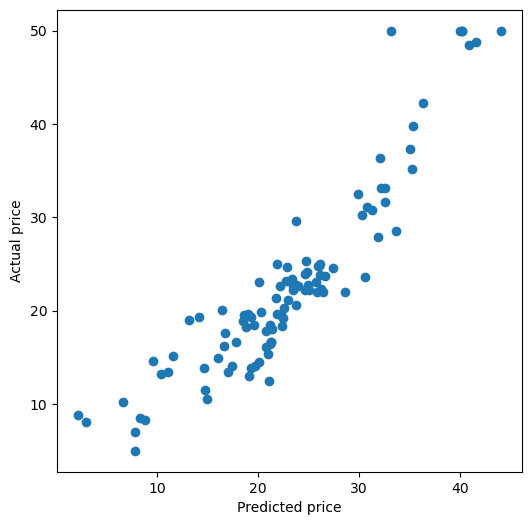

In [224]:
plt.figure(figsize=(6,6))

plt.scatter(clf.predict(val_X), val_y)
plt.xlabel(xlabel="Predicted price")
plt.ylabel(ylabel="Actual price")

Seems like the model can predict the range of the price well, but is not too accurate.